# 8. Natural Language Processing

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-example-nlp-problems.png)
*A handful of example natural language processing (NLP) and natural language understanding (NLU) problems. These are also often referred to as sequence problems (going from one sequence to another).*

Natural Language Processing (NLP) can cover many applications, including **text and speech**. Both of these types of data are known as *sequences* i.e. a sequence of words a common term in NLP is *seq2seq*, finding information from one sequence to produce another sequence. 

A couple of example applications are **spam filtering** (classification) or **analyzing customer complaints**.

Many of the steps below will be similar to the previous modules, but applied to text data.

```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

*Note: This notebook is part of a code-along creaded by Daniel Bourke and hosted on his [github](https://github.com/mrdbourke/tensorflow-deep-learning)*

## In this notebook we will work with:

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

In [1]:
# Check for GPU: Note I am not getting access to the GPU now because of how much I've been using it previously...
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-76ef2a01-401c-a9e6-df3d-5b280f59ee3e)


## Get our helper functions from previous modules

In [2]:
# Download helper functions from github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-20 20:20:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-20 20:20:40 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import relevant functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download text dataset

To start we will be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) datset from Kaggle which contains text-based Tweets about natural disasters. 

Overview of the dataset:
The Real Tweets are actually about diasters, for example:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

The Not Real Tweets are Tweets not about diasters (they can be on anything), for example:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

For convenience, the dataset has been [downloaded unchanged from Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) as to download from Kaggle you need a log-in

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-07-20 20:20:45--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-07-20 20:20:45 (118 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing the text dataset

Motto: **Visualize, Visualize, Visualize**

Step 1 is to use Pandas DataFrames.

In [5]:
# Turn .CSVs into pandas DataFrames
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle data to be sure it's shuffled
train_df_shuffled = train_df.sample(frac=1, random_state=42) # set random to 42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


The `target` column does not exist in the test dataset. This is what we want to predict using the `text` column in the training dataset

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-text-classification-inputs-and-outputs.png)
*Example text classification inputs and outputs for the problem of classifying whether a Tweet is about a diaster or not.*

In [7]:
# Look at test_df
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many samples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Fairly balanced dataset with 60% negative class (target = 0) and 40% positive class (target = 1)

In [9]:
# Counts of samples
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


For this dataset we can see that we have plenty of test data. Normally it's a 90/10 split, or 80/20, but here it's almost 50%!

As we did with images previously, let's view some random text samples

In [10]:
# Visualize some random training examples
import random

random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real distaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("--------\n")

Target: 0 (not real disaster)
Text:
@czallstarwes more like demolition derby ??

--------

Target: 0 (not real disaster)
Text:
Souda leave Lady Sonia alone or I shall obliterate you #KneelBot

--------

Target: 0 (not real disaster)
Text:
'Sometimes God uses sorrowful tragedy to set the stage for glorious redemption.' -David Platt Run forÛ_ https://t.co/86V81dv00E

--------

Target: 1 (real distaster)
Text:
IJ: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/h132iuL7MU

--------

Target: 0 (not real disaster)
Text:
School Of Seven Bells - Windstorm  http://t.co/E1kbluDwh5 #nowplaying

--------



## Split data into trainin and validation datasets

Since the test set has no labels and we need a way to evaluate our trained models, we'll split off soime of the training data and create a validation set. When our model trains it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

Additionally, we will convert the splits from pandas Series datatypes into lists of strings (for the text) and lists of ints (for the labels) for ease of use later. 

We will split using Scikit-Learn's `train_test_split()` method, and set 10% of the trainng data aside as validation data.

In [11]:
from sklearn.model_selection import train_test_split

# Split the train data into train and validation
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [12]:
# Check lengths (personally I would do this in %s too)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

Machine Learning only works well on numbers! In NLP there are two main concepts for doing this conversion.
1. **Tokenization** A direct mapping from word or character or sub-word to a numerical value. There are 3 main ways of doing this:
 
 * **Word-level tokenization**: Each word is given a numerical value
 * **Character-level tokenization**: Each character is given a numerical value
 * **Sub-word tokenization**: between the two above types of tokenization. More common on audio. e.g. "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za".

The level of tokenization depends on the specific problem. You can compare in testing/experimenting and see which perform best. It is also possible to stack them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)). 

2. **Embeddings**: An embedding is a representation of a natural language that can be learned. Representation comes in the form of a *feature vector*. For example the word 'heads' may be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. There are two ways to implement embeddings

 * **Create your own embedding** once your text has been turned into numbers (unclear: tokenized?) it can be put through an embedding layer such as `tf.keras.layers.Embedding` and the embedding representation will be learned during training
 * **Reuse a prelearned embedding** Same as with pre-trained image model weights. These are generally available online and trained on large sets of data i.e. all of Wikipedia. We can use these and then fine-tune them.  

Locations for finding pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tokenization-vs-embedding.png)
*Example of **tokenization** (straight mapping from word to number) and **embedding** (richer representation of relationships between tokens).*

## Text Vectorization

First we will learn how to apply tokenization, then we will look at embedding.

Tokenization: We will use the layer `tf.keras.experimental.preprocessing.TextVectorization`

Parameters for the above layer:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# We will use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # max  words in the vocabulary (None = all words)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # where to split
                                    ngrams=None, # create groups of k-words?
                                    output_mode="int", # how to map tokens to numbers (vs float)
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

The above cell initializes a `TextVectorization` object with the default settings, but we would like to customize it for our specific case. 

1. `max_tokens`: It is common for this to be in multiples of 10,000, or the exact number of unique words in your corpus. We will use `10,000`.
2. `output_sequence_length`: We will use the average number of tokens per Tweet in the training set (which we still need to find). 

In [15]:
# Find the average number of tokens (words) in the training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Now we will be adding our custom settings to the `TextVectorization`.

In [16]:
# Initialize text vecotrization with custom variables
max_vocab_length = 10000
max_length = 15 # Max length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

This `TextVectorization` will be mapped to our data by calling the `adapt()` method while passing it to our training data.

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Now that this is mapped, let's send it an example sentence to see what is looks like.

In [18]:
sample_text = "I am a banana"
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  8, 160,   3,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

As we can see our output fills to a vector of length 15. While this is okay with padding short sentences, I wonder how this will impact Tweets longer than 15 tokens (words)...

Let's try this on some random sentences from our trainin data.

In [19]:
# Select a random sentence from our training dataset and tokenize
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Tell him Rebahe's going to destroy himself @Zenande_Mcfen @NDzedze #Ashes2Ashes      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 639,  158, 9305,  104,    5,  305, 1661, 6500,    1,    1,    0,
           0,    0,    0,    0]])>

Lastly, let's check our unique tokens in our vocabulary using `get_vocabulary()`

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10] # most common tokens
bottom_5_words = words_in_vocab[-10:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
Bottom 5 least common words: ['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding using an Embedding Layer

Okay, so we have created a mapping to map our tokens (words) to values, which we use to create vectors for our Tweets.

What about now turning those values into embeddings? 

*Why?*:  Embeddings are powerful because they can be learned during training. This means that instead of being statis, a word's representation can be improved as a model goes through data samples (From my understanding embeddings will place similar words closer to each other in the embedding space).

Let's use a `tf.keras.layers.Embedding` layer to see what the embedding of a word looks like. 

Parameters for `tf.keras.layers.Embedding`:
* `input_dim`: The size of the vocabulary. (i.e. `len(text_vectorizer.get_vocabulary()`.
* `output_dim`: The size of the output embedding vector.
* `embeddings_initializer`: How to initialize the embeddings matrix. Default is `"uniform"` which randomly initializes embedding matrix with uniform distribution. This is adjusted when using pre-learned embeddings
* `input_length`: Length of sequences being passed to the embedding layer.

In [21]:
# Create an embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # size of embedding vector
                             embeddings_initializer="uniform", # initialize randomly
                             input_length=max_length, # length of input
                             name="embedding_1")
embedding

This output is significant because we can see that the `embedding` is a *Tensorflow layer*.

This means that we can use it as part of the model, and let its parameters (word representations) be updated as the model learns.

Let's look at a sample sentence

In [22]:
# Get random sentence
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\Embedded version:")

# Embed random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Help yourself or those you love who suffer from self-esteem wounds. You can today! http://t.co/tu6ScRSXVG http://t.co/iDhj4JBQ05      
\Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03740182,  0.03978038,  0.01312634, ...,  0.03317055,
          0.04473395,  0.02033745],
        [-0.0056263 , -0.03605131,  0.00469315, ...,  0.03750315,
         -0.02075065,  0.03189817],
        [-0.04538491,  0.02194316,  0.02299335, ...,  0.03143641,
         -0.00354359,  0.04591903],
        ...,
        [-0.01303345, -0.0456596 , -0.017446  , ..., -0.04159649,
          0.00482054, -0.00569761],
        [ 0.0291287 ,  0.02585142,  0.0255974 , ...,  0.00572053,
          0.02781173,  0.01084658],
        [ 0.03977952, -0.03782602, -0.03646283, ...,  0.00236253,
          0.03332629,  0.02803668]]], dtype=float32)>

The embedding returns a 128 length feature vector as set by `output_dim`,,

In [23]:
# Continue to check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.03740182,  0.03978038,  0.01312634,  0.04525057,  0.02647353,
       -0.01383851, -0.00156553, -0.00526694,  0.02261592,  0.01328261,
       -0.01635955, -0.02700753,  0.00973669,  0.03418609,  0.02739987,
        0.0141249 , -0.0327132 ,  0.01082782,  0.03346223, -0.02153643,
       -0.04562371,  0.02317332, -0.03271214,  0.02264846,  0.02845539,
       -0.00171893,  0.02275508,  0.00580122,  0.04756936,  0.03961797,
       -0.03917404, -0.0294854 ,  0.0359321 ,  0.02577246,  0.01569429,
       -0.03792466, -0.03001191,  0.01045021, -0.01078918, -0.00140404,
       -0.01669199,  0.01268346,  0.04778259,  0.04862589, -0.01601226,
       -0.0088468 ,  0.00142456, -0.02146822,  0.040478  ,  0.02297852,
       -0.0073338 ,  0.00043194, -0.02969912,  0.00470258,  0.00189666,
       -0.00736542, -0.015345  ,  0.03973142, -0.0251552 ,  0.04227995,
       -0.04058808,  0.01225681, -0.03755424, -0.03184002, -0.04608554,
        0.015379

This above output is what our the computer sees each word as. When our model looks for patterns in different samples, these values will be updated.

## Modelling a text dataset
![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-inputs-and-outputs-with-shapes-and-models-were-going-to-build.png)
*Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.*

Now our words are numbers. Let's build the model! 

To gain experience we are going to build plenty of models and compare the results.

* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

## Model 0: Getting a baseline

This is the original baseline model that we will use as a benchmark for our other 7 models.

We will create this baseline Naive Bayes model using Scikit-Learn Pipeline usng the TF-IDF (term frequency-inverse document frequency) formulat to convert our words to numbers and then model them with the multinomial naive bayes algorithm. 

[Scikit-Learn documentation for more](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

[Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to hte training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

Because we are using a shallow model (Multinomial Naive Bayes), the training is very fast.

Let's evaluate it though

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"The score of our baseline model is {baseline_score*100:.2f}%")

The score of our baseline model is 79.27%


In [26]:
# Make some predictions with the baseline model (model_0)
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiments

We are gonig to create a helper function that will take an array of predictions and ground truth labels and compute 

* Accuracy
* Precision
* Recall
* F1-score

*Note*: these metrics are great for classification, for regression other metrics are likely better.

In [27]:
# Function to evaluate performance metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """ 
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, and f1 score using weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1":model_f1}
  return model_results

In [28]:
baseline_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [29]:
# Return baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
print(baseline_results)

{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


## Model_1: A Simple Dense Model

The first 'deep' model that we are building is going to be a single layer dense model. 

This model will take the text and labels ad input, tokeniuze the text, create an embedding, find the average of the embedding (Global Average Pooling) and then pass the average through a fully connected (dense) layer with one output unit and a sigmoid activation function.

Since we are going to be building numerous TensorFlow models we will import the `create_tensorboard_callback()` function.

In [30]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create save directory for TB callback
SAVE_DIR = "model_logs"

In [31]:
# Build model_1 with the functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1D strings
x = text_vectorizer(inputs) # turn input text into numbers
x = embedding(x) # create an embedding of the text converted to numbers
x = layers.GlobalAveragePooling1D()(x) # dimensionality reduction to 1D output
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so using sigmoid
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

What does this model do?

1) Take a 1D string as input

2) Tokenizes using the `text_vecotorizer` function

3) Creates an embedding using `embedding`

4) Pass the output of hte pooling layer to a desnse layer with sigmoid activation

Next we need to compile our model. Because we are dealing with two classes, we will use `binary_crossentropy`. We will also keep with the `Adam()` optimizer.

In [32]:
# Compile model_1
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [33]:
# Summary of model_1
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

As we can see, most of the trainable parameters are contained within the embedding layer. Since we have 128 dim embedding, and 10,000 vocab (words) we have 1,280,000 trainable parameters in this layer.

Let's try training for 5 epochs (don't forget TensorBoard callback)

In [34]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model_1")])

Saving TensorBoard log files to: model_logs/simple_dense_model_1/20220720-202054
Epoch 1/5
215/215 [==============================] - 8s 9ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [35]:
# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.47668465971946716, 0.787401556968689]

In [36]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073165,  0.01504801, -0.03425454, ..., -0.04403536,
         -0.01042283,  0.01876437],
        [ 0.04135862, -0.03945085, -0.03811943, ...,  0.00464735,
          0.03163549,  0.029283  ],
        [ 0.00684032,  0.05363132, -0.00241554, ..., -0.07082175,
         -0.04750704,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.0619906 ,
         -0.01018393,  0.03510419],
        [-0.03723461,  0.06267187, -0.07451147, ..., -0.02367218,
         -0.0864333 ,  0.01742156]], dtype=float32)>]

In [37]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Let's leverage the TensorBoard callback to visualize out model's logs

In [38]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tensorboard-dense-model-training-curves.png)

In [39]:
# Make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.40488204],
       [0.7443312 ],
       [0.997895  ],
       [0.10889999],
       [0.11143532],
       [0.93556094],
       [0.9134595 ],
       [0.9925345 ],
       [0.97156817],
       [0.26570338]], dtype=float32)

Since our output layer uses a sigmoid activation function, we get these probabilities returned as our predictions.

Essentially we just round them using `tf.round()` to get 0 or 1. But we also get insights into how certain the network is.

*Note:* In practice, the output threshold of a sigmoid prediction probability doesn't necessarily have to 0.5. For example, through testing, you may find that a cut off of 0.25 is better for your chosen evaluation metrics. A common example of this threshold cutoff is the [precision-recall tradeoff](https://www.machinelearningaptitude.com/topics/machine-learning/what-is-precision-recall-tradeoff/#:~:text=precision%2Drecall%20tradeoff%20occur%20due,the%20threshold%20of%20the%20classifier.&text=When%20threshold%20is%20decreased%20to,but%20precision%20decreases%20to%200.4.).

In [40]:
# Turn prediciton probabilities into tensor of floats
model_1_preds = tf.round(model_1_pred_probs)
model_1_preds

<tf.Tensor: shape=(762, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
 

In [41]:
# Turn prediciton probabilities into single-dimension tensor of floats

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

This now outputs our model's predictiosn in the form of classes which can be used in our `calculate results()` function to compare them to the ground truth validation labels

In [42]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

Let's compare to our model_0

In [43]:
# Is our simple model better than the baseline?
import numpy as np

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Looks like it is not better.

We will do this often, so let's make a function of it.

In [44]:
# Create helper function to compare baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Visualizing learning embeddings

`model_1` contains an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing ovewr the training data.

To help us better understand the embedding layer let's try to visualize it a bit.

In [45]:
# Remind ourselves of the words in our vocab
# Get the vocab from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [47]:
# Get the weight of the embedding layer
# Note: these are the numerical patterns between the text adn the training dataset the model has learned

embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding. 

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).


In [48]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:
1. Go to  http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (`embedding_vectors.tsv` and `embedding_metadata.tsv`)

Note: words with similar meanings shouuld be close together.

## Recurrent Neural Networks (RNNs)

For the next models we will be using a type of NN known as **Recurrent Neural Network**.

RNNs use information from the past to help with the future.  It takes an input and computes an output based on all previous results, though the weights of earlier previous results decreases rapidly.

This concept is great for short passages of natural text as it provides some context.

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

Most applications of RNNs are of the following variants: 
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

For a deeper understanding of what's happening check out the following resources:

* [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
* [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.


## Model_2: LSTM

This will be an LSTM-powered LSTM leveraging `tensorflow.keras.layers.LSTM()`.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)
*Coloured block example of the structure of an recurrent neural network.*

The structure of model_2 will be very similar to that of model_1. (Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probabilities))

To ensure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

In [49]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers

model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create the LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [50]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

model_2 has more trainable parameters than model_1.

Let's fit with out TB callback

In [52]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220720-202109
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


Let's make some predictions now. We have the same sigmoid activation layer as with model_1 so we need to `tf.round()` and `tf.squeeze` again.

In [53]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((762, 1), array([[0.007126  ],
        [0.7873678 ],
        [0.9996376 ],
        [0.05679173],
        [0.00258219],
        [0.9996238 ],
        [0.9217021 ],
        [0.9997993 ],
        [0.9994954 ],
        [0.6645738 ]], dtype=float32))

In [54]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Let's calcualte our results from model_2 and compare it to the baseline

In [55]:
# Calcualte results of the LSTM model
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'f1': 0.7489268622514025,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026}

In [56]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


## Model_3 GRU

Alternatively to LSTM there is the **GRU** or *Gated Recurrent Unit*.

A GRU cell has similar features to an LSTM but with less parameters.

We will use `tf.keras.layers.GRU()` to create a GRU layer wiin tensorflow.

A few resources to dig into GRUs further:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

In [57]:
# Set random seed and create new embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [58]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

In [60]:
# fit model_3
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220720-202122
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [61]:
# Predictions on the val_data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[0.33325258],
        [0.87741184],
        [0.9980252 ],
        [0.11561756],
        [0.01235959],
        [0.9925639 ],
        [0.6214262 ],
        [0.99813336],
        [0.9982377 ],
        [0.5018107 ]], dtype=float32))

In [62]:
# Convert to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7667932666650168,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708}

In [64]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Model_4: Bidirectional RNN model

`model_4` will be a **bidirectional RNN**. A standard RNN will process a sequence from left to right, where a bidirectional RNN will process the sequence from left to right and then again from the right to the left.

Bidirectional RNNs are a tried and true way of improving perfomance in many applications. The downside being that the training time is increased and the number of model parameters is doubled. 

We will implement this bidirectional layer with the `tf.keras.layers.Bidirectional` class. We can use this to wrap out existing RNNs.

In [65]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a bidirectional RNN in TensorFlow
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [66]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

From the summary output we can see that the bidirectionality that we added to the model has significantly increased the number of trainable parameters.

In [68]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220720-202138
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [69]:
# Making some predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.04000054],
       [0.8279291 ],
       [0.99842227],
       [0.13531098],
       [0.00311338],
       [0.99220747],
       [0.95528346],
       [0.99945647],
       [0.99898285],
       [0.2814168 ]], dtype=float32)

In [70]:
# Convert prediction probabilities to class labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate results for model_4
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7651213533864446,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657}

In [72]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [73]:
# Running compare against all as a reminder
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [74]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


In [75]:
compare_baseline_to_new_results(baseline_results, model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


Weird. It seems like none of these are better really than the simple baseline. What's going on?

## Model_5: Conv1D

Beforfe we build a full 1-D CNN model we are going to build a 1-D convolutional layer (aka **temporal convolution**) in action.

This involves 

(1) embedding 

(2) Conv1D() 

(3) GlobalMaxPool1D

The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.


In [76]:
# Test out the embedding, 1D conv and maxpooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over the target sequence 5 words (kernels?) at a time
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Remember we set our input length to 15...

In [77]:
# See each layers' outputs
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02534915, -0.03109057,  0.00285616, ..., -0.00783159,
          -0.02685575, -0.04434131],
         [-0.06586257,  0.09451495, -0.01477601, ..., -0.00657781,
          -0.04238791,  0.07777896],
         [-0.04803654, -0.00709756, -0.02330893, ..., -0.01807331,
           0.02351035,  0.02676385],
         ...,
         [ 0.00073165,  0.01504801, -0.03425454, ..., -0.04403536,
          -0.01042283,  0.01876437],
         [ 0.00073165,  0.01504801, -0.03425454, ..., -0.04403536,
          -0.01042283,  0.01876437],
         [ 0.00073165,  0.01504801, -0.03425454, ..., -0.04403536,
          -0.01042283,  0.01876437]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08324981, 0.00648718, 0.        , 0.03983573, 0.        ,
          0.01144417, 0.00416251, 0.02288391, 0.        , 0.00900979,
          0.        , 0.        , 0.0340177 , 0.06408274, 0.08103721,
          0.00409015, 0.

Let's create a model now that we have seen some individual outputs

In [78]:
# Set random seed and create new embedding
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1D conv. layer
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1D")

# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [79]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220720-202202
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [80]:
# Make predictions model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.22534487],
       [0.7534112 ],
       [0.9995602 ],
       [0.0556279 ],
       [0.01449847],
       [0.9858518 ],
       [0.98418933],
       [0.99758804],
       [0.99862623],
       [0.26914388]], dtype=float32)

In [81]:
# Convert model_5 predictions to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'f1': 0.7758810170952618,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129}

In [83]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## Using Pretained embeddings (transfer learning!)

We're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

### Model_6: TensorFlow Hub Pretrained Sentence Encoder

The `Universal Sentence Encoder` creates an embedding at a whole-sentence level, compared to the embedding layer we made which was word-level. 

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)
*The feature extractor model we're building through the eyes of an **encoder/decoder** model.*

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [84]:
# Example of a pretrained embedding wit huniversal sentence encoder
import tensorflow_hub as hub
sample_sentence = "There's a flood in my street!"

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [85]:
embed_samples[0].shape

TensorShape([512])

When we pass a sentence toi the Unisersal Sentence Encoder (USE) they are encoded from strings into 512 dimensional vectors.

Let's build one!

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

In [86]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

Now we've got the USE as a Keras layer, we can use it in a Keras Sequential model.

In [87]:
# Create a model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Note the trainable parameters are only in the dense layers that we created.

In [88]:
# Train a classifier on top of the pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220720-202240
Epoch 1/5
215/215 [==============================] - 6s 13ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [89]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.14443196],
       [0.72715044],
       [0.9856655 ],
       [0.19740927],
       [0.73417014],
       [0.6859662 ],
       [0.9808888 ],
       [0.97411025],
       [0.9157322 ],
       [0.08070081]], dtype=float32)

In [90]:
# Convert to label predictions
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [91]:
# Calculate performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'f1': 0.810686575717776,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494}

In [92]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


### Model_7: TensorFlow Hub pretrained senence encoder, trained on 10% of training data

So we see just pulling in the pretrained weights has alright performance, but one of the benefits is to boost it further with minimal training on our custom data

In [93]:
# Create subset data
train_sentences_90_pct, train_sentences_10_pct, train_labels_90_pct, train_labels_10_pct = train_test_split(np.array(train_sentences),
                                                                                                            train_labels,
                                                                                                            test_size=0.1,
                                                                                                            random_state=42)

In [94]:
# check length of training datasets
print(f"total length of training examples: {len(train_sentences)}")
print(f"length of 10% training examples: {len(train_labels_10_pct)}")

total length of training examples: 6851
length of 10% training examples: 686


Let's check to make sure that the random sampling of our training data is still mostly balanced...

In [95]:
# Check training label counts
pd.Series(train_labels_10_pct).value_counts()

0    415
1    271
dtype: int64

We will create model_7 from a copy of model_6 using `tf.keras.model.clone_model()`. This will keep the same architecture, but reset the weights.

In [96]:
# Clone model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [97]:
# Fit the model_7 to the 10% training data
model_7_history = model_7.fit(x=train_sentences_10_pct,
                              y=train_labels_10_pct,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20220720-202306
Epoch 1/5
22/22 [==============================] - 8s 131ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 56ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 42ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 44ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 51ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [98]:
# Make predictions, turn into labels
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

In [99]:
# Results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'f1': 0.7667059443150692,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814}

In [100]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Compare the performance of each of our models

We made a lot of models! Let's compare them!

*Note: This process of creating numerous models and then comparing them is pretty standard.

We will visualize our model performances using a pandas DataFrame.

In [101]:
# Combike model results into a DataFrame
all_model_results = pd.DataFrame({"baseline:": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline:,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.034121,0.775563,0.770341,0.766706


In [102]:
# Convert accuracy to decimal
all_model_results["accuracy"] = all_model_results["accuracy"]/100

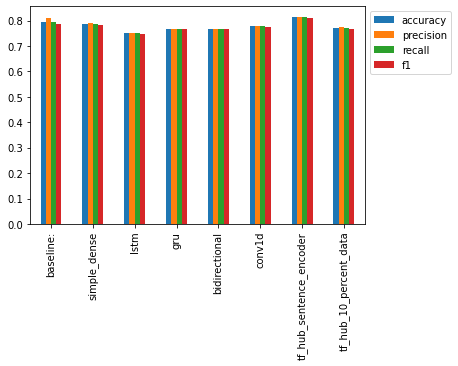

In [103]:
# Plot all results
all_model_results.plot(kind="bar").legend(bbox_to_anchor=(1.0,1.0))

We can see that the model that used the pretrained USE weights perfoms the best. Even the 10% version performs better than the others.

Drill-down to the F1 scores only

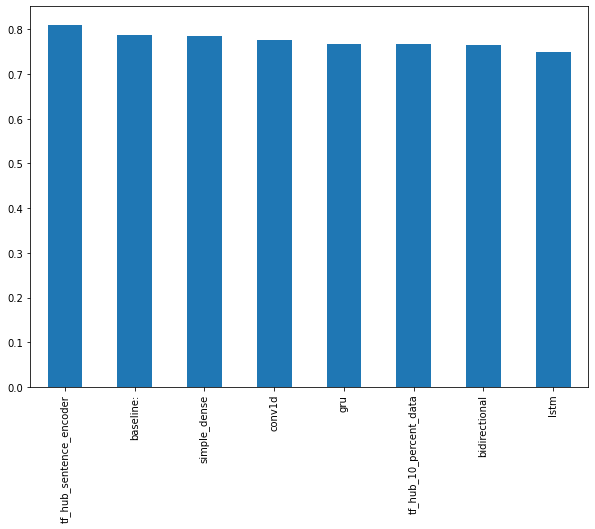

In [104]:
# Sort models by F1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

Can also visualize using TensorBoard

In [105]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

In [106]:
# To remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

## Combining our models (creating an `ensemble` model)

Many neural networks in production models use an **ensemble** (aka a combination) of models to make predictions.

The macro idea is that if several uncorrelated models agree on a prediction, that the prediction is more likely to be true. 

In our case uncorrelated does not mean that they are trained on unrelated data, but that they are structured differenlty for pattern recognition. 


**Ways of combining our models**:
1. *Averaging*: Take the output prediction probabilities of each model for each sample and combine and then average
2. *Majority Vote*: The most chosen class
3. *Model Stacking*: Take the outputs of each of the models and use them as inputs to another model

(These methods have been adapted from Ch. 6 of the [Machine Learning Engineering Book](http://www.mlebook.com/wiki/doku.php) by Andriy Burkov.

We are going to combine the baseline model (`model_0`) with the LSTM model (`model_2`) and the 100% USE model (`model_6`) through averaging the combined prediction probabilities.  

In [107]:
# Calcualte mean pred_probs for the chosen models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [108]:
# Calculate ensemble predictions
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'f1': 0.7805169025578647,
 'precision': 0.7805216999297674,
 'recall': 0.7808398950131233}

In [109]:
# Let's add this to our DataFrame so that we can compare to our single model results more easily
all_model_results.loc["ensemble_results"] = ensemble_results
all_model_results

,accuracy,precision,recall,f1
baseline:,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.750656,0.751008,0.750656,0.748927
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
tf_hub_10_percent_data,0.770341,0.775563,0.770341,0.766706
ensemble_results,78.083990,0.780522,0.780840,0.780517


Well it looks like our models are all very close. We did only train for 5 epochs on each...

But it is also good after training for a bit more to revisit the data if many moidels are performing very closely.

## Saving and loading the trained model

Always good practice to save your trained models to avoid needing to retrain them. It also allows for export and use elsewhere.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format. 
2. The `SavedModel` format (default).

We will look at both


In [110]:
# Save TF Hub Sentence Encoder model to HDF5 Format
model_6.save("model_6.h5")

When loading back in a file saves as HDF5 you *need to let TensorFlow know about any custom objects*. For example, we used TensorFlow Hub which isn't part of the pure TensorFlow package.

In [116]:
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [118]:
loaded_model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [119]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

When calling the `save()` method and passaing a filepath we can save our model in the `SavedModel` format

In [120]:
# Save TF Hub Sentence Encoder model to SavedModel format
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


When using the `SavedModel` format you don't need to call specific custom objects.

In [121]:
# Load SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [122]:
# Evaluate the loaded model
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 18ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

Same performance between saves! So... why use one over the other?

Generally the `SavedModel` will be best, but this is a TensorFlow standard. If you need a more general-purpose data standard then `HDF5` might be better.

## Finding the most wrong predictions

As highlighted before if all our models are returning similar performance it is a good idea to dig into the data.

One of the best ways of exploring data is to see what predictions are the most wrong. Let's *visualize* this.

* If our best model still isn't perfect, what examples is it getting wrong?
* Which ones are the most wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [125]:
# Create DataFrame wqith validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144432
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.727150
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985666
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197409
4,Radiation emergency #preparedness starts with ...,1,1.0,0.734170


Now let's find the wrong preditions, and sort

In [127]:
# Find wrong predictions and sort by pred_prob
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:20]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910481
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864676
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.837961
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.836361
628,@noah_anyname That's where the concentration c...,0,1.0,0.835225
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834875
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.800890
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.782611
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782433
144,The Sound of Arson,0,1.0,0.771343


Let's write some code to visualize the sample text, truth label, prediction class, and prediction probability.

Note:

0 = Not a real disaster
1 = Real disaster

In [129]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9104807376861572
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8646755218505859
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8379610776901245
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8363614082336426
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8352250456809998
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8348746299743652
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Pr

View the bottom of the `most_wrong` dataframe to inspect false negatives

In [130]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06304335594177246
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.06279505044221878
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.06060810014605522
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.0573178268969059
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.045355550944805145
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.041451383382081985
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03926115110516548
Text:
@SoonerMagic_ I mean I'm a fan but 

Hmmm... looks like some of our labels might not be right!!

## Making predictions on the test dataset.

Since these don't have labels we will need to inspect them ourselves to gauge performance


In [131]:
# Prediction on test_dataset examples

test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 0, Prob: 0.17207098007202148
Text:
This beautifully rapturous facade that we've poured life into has itself given birth to a deplorable fate our total obliteration.

----

Pred: 0, Prob: 0.1446925401687622
Text:
While being held hostage by Tobias Hankel

----

Pred: 0, Prob: 0.3151742219924927
Text:
@Schwarzenegger @FoxNews you won't because Dems are focused on flooding our borders with illegal immigrants to add to their voters. #EndofUS

----

Pred: 1, Prob: 0.8320173621177673
Text:
'Prompt and utter' mass murder  https://t.co/BRU7t5UzUy

----

Pred: 1, Prob: 0.6474711894989014
Text:
I'm havin previous life flashbacks of when i lived in Weimar Berlin. the hustlin life on Unter der Linden before the deluge.

----

Pred: 1, Prob: 0.9904928803443909
Text:
@wral there are now 5 fire trucks and 2 ambulances at Wellington ridge lp in Cary. one of the units is on fire. not sure on injuries

----

Pred: 1, Prob: 0.8003494143486023
Text:
Great photo by the Tribune's Terrence Antonio Jame

## Speed-Score tradeoff

Just because a model is the best performing, doesn't mean that it is the best model to use. When dealing with large datasets you need to udnerstand that speed may be more important than absolute accuracy/F1-score/etc. 

In [132]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [133]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.37610312599986173, 0.0004935736561677976)

In [134]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.022198236999884102, 2.9131544619270474e-05)

Wow quite a difference! Factor of 10!

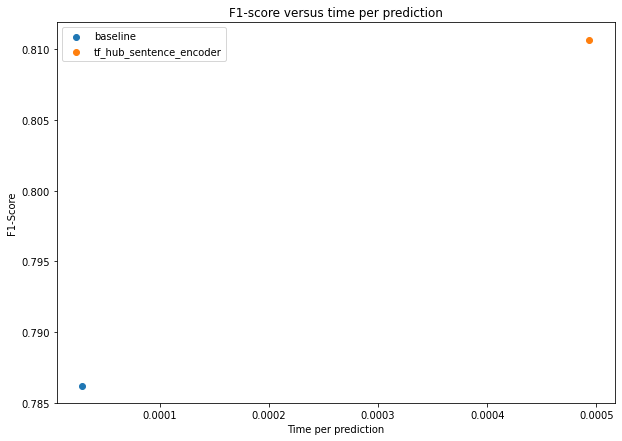

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

The ideal location would be on the top left. Fast, and high score!